# GRU 303
Start with GRU 301 which did train on long, test on short.
Here train on all, test on long.

In [ ]:
TRAIN_NC_FILENAME='ncRNA.gc36.all.fasta'
TRAIN_PC_FILENAME='pcRNA.gc36.all.fasta'
VALID_NC_FILENAME='ncRNA.gc36.long.fasta'
VALID_PC_FILENAME='pcRNA.gc36.long.fasta'
#NC_FILENAME='ncRNA.tiny50.fasta'
#PC_FILENAME='pcRNA.tiny50.fasta'
#NC_FILENAME='ncRNA.gc34.processed.fasta'
#PC_FILENAME='pcRNA.gc34.processed.fasta'

MODEL_FILE='JUNK1'  # change this if you want to keep models
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
TRAIN_NC_FILENAME = DATAPATH+TRAIN_NC_FILENAME
TRAIN_PC_FILENAME = DATAPATH+TRAIN_PC_FILENAME
VALID_NC_FILENAME = DATAPATH+VALID_NC_FILENAME
VALID_PC_FILENAME = DATAPATH+VALID_PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=200
SPLITS=5
ONEHOT=5  
NEURONS=64
DROP=0.10
ACT="tanh"
MINLEN=201
MAXLEN=2000
LIMIT=5588    # This is the size of our smallest set (protein coding short)

Mounted at /content/drive/


In [ ]:
# Load our own tools
# TO DO: don't go to GitHub if the file is already local.
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [ ]:
def compile_model(model):
    ## learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    #adam_default_learn_rate = 0.001
    #schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #    initial_learning_rate = adam_default_learn_rate*10,
    #    decay_steps=10000, decay_rate=0.99, staircase=True)
    #alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])

    print("COMPILE...")
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    MASK=[0,0,0,0,1] # to do: get one_hot('N') from the one_hot() function.
    mask_layer = keras.layers.Masking(mask_value=MASK, input_shape=[MAXLEN,ONEHOT])
    rlayer1 = keras.layers.GRU(NEURONS, return_sequences=True, 
        activation=ACT, dropout=DROP )  
    rlayer2 = keras.layers.GRU(NEURONS, return_sequences=True, 
        activation=ACT, dropout=DROP) 
    rlayer3 = keras.layers.GRU(NEURONS, return_sequences=True, 
        activation=ACT, dropout=DROP) 
    rlayer4 = keras.layers.GRU(NEURONS, return_sequences=False, 
        activation=ACT, dropout=DROP) 

    dlayer1 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer2 = keras.layers.Dropout(DROP)
    dlayer3 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer4 = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)

    rnn = keras.models.Sequential()
    rnn.add(mask_layer)
    rnn.add(rlayer1)
    rnn.add(rlayer2)
    rnn.add(rlayer3)
    rnn.add(rlayer4)
    rnn.add(dlayer1)
    rnn.add(dlayer2)
    rnn.add(dlayer3)
    rnn.add(dlayer4)
    rnn.add(output_layer)
    compiled = compile_model(rnn)
    return compiled

Cross validation

In [ ]:
def do_cross_validation(X_train,y_train,given_model,X_valid,y_valid):
    cv_scores = []
    fold=0
    # When not using ShuffleSplit, make sure to randomize train data.
    #splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    #for train_index,valid_index in splitter.split(X):
    while fold < SPLITS:
        fold += 1
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        es = keras.callbacks.EarlyStopping(monitor='val_loss',  
            patience=10, verbose=1)
        mc = keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')  
        mycallbacks = [es,mc]  
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks, shuffle=True,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  

    print()
    print("%d-way Cross Validation max %.2f%%, mean %.2f%% (+/- %.2f%%)" % 
          (fold, np.amax(cv_scores), np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [ ]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
#model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 2000, 5)           0         
_________________________________________________________________
gru (GRU)                    (None, 2000, 64)          13632     
_________________________________________________________________
gru_1 (GRU)                  (None, 2000, 64)          24960     
_________________________________________________________________
gru_2 (GRU)                  (None, 2000, 64)          24960     
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_____________________________________________________________

In [ ]:
def load_data(nc_filename,pc_filename,limit=None):
  nc_seq=tools.load_fasta(nc_filename,0)
  pc_seq=tools.load_fasta(pc_filename,1)
  if limit is not None:
    # Choose a random subset of size = limit.
    # Side effect: randomizes the data order.
    nfrac=1.0*limit/len(nc_seq)
    pfrac=1.0*limit/len(pc_seq)
    if nfrac<1.0:
      nc_seq=nc_seq.sample(frac=nfrac)
    if pfrac<1.0:
      pc_seq=pc_seq.sample(frac=pfrac)
  train_set=pd.concat((nc_seq,pc_seq),axis=0)
  # May not need to slice by length if input files already sliced
  subset=tools.make_slice(train_set,MINLEN,MAXLEN)
  # randset=subset.sample(frac=1) # unneccessary with fit(shuffle)
  (X1,y1)=tools.separate_X_and_y(subset)
  # X1 is pandas df of ("list" of one sequence)
  X2=X1.to_numpy()  # numpy ndarray of ("list" of one sequence)
  X3=[elem[0] for elem in X2]  # numpy dnarray of str
  X4=tools.uniform_length(X3,MAXLEN)
  X5= [tools.one_hot(x) for x in X4]  
  # one-hot leaves ONEHOT=5. TO DO: set 5 automatically
  X6=np.asarray(X5)
  y6=y1.to_numpy()
  return X6,y6

print("Load train data from files.")
X_train,y_train = load_data(TRAIN_NC_FILENAME,TRAIN_PC_FILENAME,LIMIT)
print("X_train",X_train.shape)
print(X_train[1])
print("Load valid data from files.")
X_valid,y_valid = load_data(VALID_NC_FILENAME,VALID_PC_FILENAME,LIMIT)
print("X_valid",X_valid.shape)

Load train data from files.
X_train (11176, 2000, 5)
[[0 1 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]
Load valid data from files.
X_valid (11176, 2000, 5)


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 144s 366ms/step - loss: 0.6800 - accuracy: 0.5660 - val_loss: 0.6903 - val_accuracy: 0.5362


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 2/200
350/350 [==============================] - 124s 356ms/step - loss: 0.6743 - accuracy: 0.5920 - val_loss: 0.6985 - val_accuracy: 0.5310
Epoch 3/200
350/350 [==============================] - 127s 363ms/step - loss: 0.6745 - accuracy: 0.5789 - val_loss: 0.6980 - val_accuracy: 0.5179
Epoch 4/200
350/350 [==============================] - 131s 374ms/step - loss: 0.6755 - accuracy: 0.5757 - val_loss: 0.6920 - val_accuracy: 0.5308
Epoch 5/200
350/350 [==============================] - 130s 372ms/step - loss: 0.6586 - accuracy: 0.6091 - val_loss: 0.6985 - val_accuracy: 0.5409


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 6/200
350/350 [==============================] - 130s 373ms/step - loss: 0.6650 - accuracy: 0.5999 - val_loss: 0.6579 - val_accuracy: 0.6161


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 7/200
350/350 [==============================] - 129s 370ms/step - loss: 0.6761 - accuracy: 0.5646 - val_loss: 0.6796 - val_accuracy: 0.5629
Epoch 8/200
350/350 [==============================] - 130s 373ms/step - loss: 0.6846 - accuracy: 0.5523 - val_loss: 0.6752 - val_accuracy: 0.5532
Epoch 9/200
350/350 [==============================] - 131s 375ms/step - loss: 0.6724 - accuracy: 0.5783 - val_loss: 0.6688 - val_accuracy: 0.5912
Epoch 10/200
350/350 [==============================] - 131s 375ms/step - loss: 0.6081 - accuracy: 0.6696 - val_loss: 0.5679 - val_accuracy: 0.7068


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 11/200
350/350 [==============================] - 131s 374ms/step - loss: 0.5543 - accuracy: 0.7265 - val_loss: 0.5554 - val_accuracy: 0.7204


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 12/200
350/350 [==============================] - 131s 373ms/step - loss: 0.5283 - accuracy: 0.7499 - val_loss: 0.5337 - val_accuracy: 0.7347


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 13/200
350/350 [==============================] - 129s 370ms/step - loss: 0.5227 - accuracy: 0.7407 - val_loss: 0.5183 - val_accuracy: 0.7457


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 14/200
350/350 [==============================] - 128s 367ms/step - loss: 0.5017 - accuracy: 0.7596 - val_loss: 0.6116 - val_accuracy: 0.7224
Epoch 15/200
350/350 [==============================] - 131s 375ms/step - loss: 0.5003 - accuracy: 0.7597 - val_loss: 0.5786 - val_accuracy: 0.7226
Epoch 16/200
350/350 [==============================] - 130s 373ms/step - loss: 0.4661 - accuracy: 0.7837 - val_loss: 0.4407 - val_accuracy: 0.7871


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 17/200
350/350 [==============================] - 132s 378ms/step - loss: 0.4470 - accuracy: 0.7890 - val_loss: 0.5186 - val_accuracy: 0.7421
Epoch 18/200
350/350 [==============================] - 134s 384ms/step - loss: 0.5078 - accuracy: 0.7586 - val_loss: 0.4838 - val_accuracy: 0.7691
Epoch 19/200
350/350 [==============================] - 130s 372ms/step - loss: 0.4957 - accuracy: 0.7558 - val_loss: 0.5108 - val_accuracy: 0.7513
Epoch 20/200
350/350 [==============================] - 132s 376ms/step - loss: 0.4708 - accuracy: 0.7769 - val_loss: 0.4535 - val_accuracy: 0.7915


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 21/200
350/350 [==============================] - 135s 385ms/step - loss: 0.4563 - accuracy: 0.7821 - val_loss: 0.4359 - val_accuracy: 0.8077


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 22/200
350/350 [==============================] - 135s 387ms/step - loss: 0.4375 - accuracy: 0.7937 - val_loss: 0.4072 - val_accuracy: 0.8142


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 23/200
350/350 [==============================] - 137s 391ms/step - loss: 0.4378 - accuracy: 0.7966 - val_loss: 0.4102 - val_accuracy: 0.8124
Epoch 24/200
350/350 [==============================] - 137s 393ms/step - loss: 0.4395 - accuracy: 0.7932 - val_loss: 0.4689 - val_accuracy: 0.7701
Epoch 25/200
350/350 [==============================] - 137s 392ms/step - loss: 0.4350 - accuracy: 0.7899 - val_loss: 0.5460 - val_accuracy: 0.7200
Epoch 26/200
350/350 [==============================] - 137s 393ms/step - loss: 0.5088 - accuracy: 0.7475 - val_loss: 0.5317 - val_accuracy: 0.7492
Epoch 27/200
350/350 [==============================] - 139s 397ms/step - loss: 0.4493 - accuracy: 0.7874 - val_loss: 0.4670 - val_accuracy: 0.7752
Epoch 28/200
350/350 [==============================] - 137s 393ms/step - loss: 0.4162 - accuracy: 0.8035 - val_loss: 0.3846 - val_accuracy: 0.8289


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 29/200
350/350 [==============================] - 137s 393ms/step - loss: 0.4152 - accuracy: 0.8065 - val_loss: 0.4439 - val_accuracy: 0.7939
Epoch 30/200
350/350 [==============================] - 137s 392ms/step - loss: 0.4045 - accuracy: 0.8153 - val_loss: 0.3742 - val_accuracy: 0.8295


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 31/200
350/350 [==============================] - 137s 391ms/step - loss: 0.3801 - accuracy: 0.8245 - val_loss: 0.4276 - val_accuracy: 0.8012
Epoch 32/200
350/350 [==============================] - 139s 396ms/step - loss: 0.3714 - accuracy: 0.8320 - val_loss: 0.3608 - val_accuracy: 0.8372


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 33/200
350/350 [==============================] - 139s 398ms/step - loss: 0.4704 - accuracy: 0.7793 - val_loss: 0.4414 - val_accuracy: 0.7891
Epoch 34/200
350/350 [==============================] - 139s 399ms/step - loss: 0.4610 - accuracy: 0.7882 - val_loss: 0.4115 - val_accuracy: 0.8079
Epoch 35/200
350/350 [==============================] - 139s 397ms/step - loss: 0.4156 - accuracy: 0.8058 - val_loss: 0.3526 - val_accuracy: 0.8456


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 36/200
350/350 [==============================] - 139s 398ms/step - loss: 0.3870 - accuracy: 0.8199 - val_loss: 0.5921 - val_accuracy: 0.6898
Epoch 37/200
350/350 [==============================] - 138s 396ms/step - loss: 0.3882 - accuracy: 0.8205 - val_loss: 0.3354 - val_accuracy: 0.8505


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 38/200
350/350 [==============================] - 139s 399ms/step - loss: 0.3685 - accuracy: 0.8323 - val_loss: 0.3325 - val_accuracy: 0.8559


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 39/200
350/350 [==============================] - 139s 398ms/step - loss: 0.3523 - accuracy: 0.8454 - val_loss: 0.3356 - val_accuracy: 0.8599


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 40/200
350/350 [==============================] - 140s 399ms/step - loss: 0.3413 - accuracy: 0.8529 - val_loss: 0.3320 - val_accuracy: 0.8565
Epoch 41/200
350/350 [==============================] - 138s 394ms/step - loss: 0.3336 - accuracy: 0.8544 - val_loss: 0.3164 - val_accuracy: 0.8649


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 42/200
350/350 [==============================] - 139s 397ms/step - loss: 0.3400 - accuracy: 0.8449 - val_loss: 0.3327 - val_accuracy: 0.8563
Epoch 43/200
350/350 [==============================] - 139s 396ms/step - loss: 0.3450 - accuracy: 0.8400 - val_loss: 0.3428 - val_accuracy: 0.8446
Epoch 44/200
350/350 [==============================] - 139s 399ms/step - loss: 0.3609 - accuracy: 0.8416 - val_loss: 0.3281 - val_accuracy: 0.8566
Epoch 45/200
350/350 [==============================] - 139s 398ms/step - loss: 0.3490 - accuracy: 0.8443 - val_loss: 0.3125 - val_accuracy: 0.8722


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 46/200
350/350 [==============================] - 139s 397ms/step - loss: 0.3383 - accuracy: 0.8495 - val_loss: 0.2937 - val_accuracy: 0.8819


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 47/200
350/350 [==============================] - 138s 396ms/step - loss: 0.3271 - accuracy: 0.8602 - val_loss: 0.2843 - val_accuracy: 0.8835


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 48/200
350/350 [==============================] - 138s 395ms/step - loss: 0.3097 - accuracy: 0.8645 - val_loss: 0.2832 - val_accuracy: 0.8869


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 49/200
350/350 [==============================] - 139s 398ms/step - loss: 0.3085 - accuracy: 0.8716 - val_loss: 0.2719 - val_accuracy: 0.8936


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 50/200
350/350 [==============================] - 139s 397ms/step - loss: 0.2920 - accuracy: 0.8719 - val_loss: 0.2601 - val_accuracy: 0.8993


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 51/200
350/350 [==============================] - 138s 394ms/step - loss: 0.2841 - accuracy: 0.8815 - val_loss: 0.2490 - val_accuracy: 0.9043


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 52/200
350/350 [==============================] - 140s 401ms/step - loss: 0.2844 - accuracy: 0.8795 - val_loss: 0.2644 - val_accuracy: 0.8938
Epoch 53/200
350/350 [==============================] - 139s 397ms/step - loss: 0.3297 - accuracy: 0.8562 - val_loss: 0.2831 - val_accuracy: 0.8871
Epoch 54/200
350/350 [==============================] - 140s 400ms/step - loss: 0.2782 - accuracy: 0.8831 - val_loss: 0.2602 - val_accuracy: 0.8943
Epoch 55/200
350/350 [==============================] - 139s 397ms/step - loss: 0.2567 - accuracy: 0.8927 - val_loss: 0.2544 - val_accuracy: 0.8983
Epoch 56/200
350/350 [==============================] - 139s 396ms/step - loss: 0.2624 - accuracy: 0.8913 - val_loss: 0.2590 - val_accuracy: 0.8958
Epoch 57/200
350/350 [==============================] - 139s 398ms/step - loss: 0.2523 - accuracy: 0.8939 - val_loss: 0.2346 - val_accuracy: 0.9096


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.1.best/assets


Epoch 58/200
350/350 [==============================] - 139s 397ms/step - loss: 0.2552 - accuracy: 0.8937 - val_loss: 0.2375 - val_accuracy: 0.9088
Epoch 59/200
350/350 [==============================] - 138s 396ms/step - loss: 0.2422 - accuracy: 0.9034 - val_loss: 0.2618 - val_accuracy: 0.8947
Epoch 60/200
350/350 [==============================] - 138s 394ms/step - loss: 0.3487 - accuracy: 0.8448 - val_loss: 0.3121 - val_accuracy: 0.8652
Epoch 61/200
350/350 [==============================] - 138s 396ms/step - loss: 0.3250 - accuracy: 0.8590 - val_loss: 0.3137 - val_accuracy: 0.8607
Epoch 62/200
350/350 [==============================] - 137s 392ms/step - loss: 0.3094 - accuracy: 0.8667 - val_loss: 0.2744 - val_accuracy: 0.8855
Epoch 63/200
350/350 [==============================] - 138s 394ms/step - loss: 0.2886 - accuracy: 0.8806 - val_loss: 0.3506 - val_accuracy: 0.8458
Epoch 64/200
350/350 [==============================] - 139s 397ms/step - loss: 0.2868 - accuracy: 0.8768 - val_

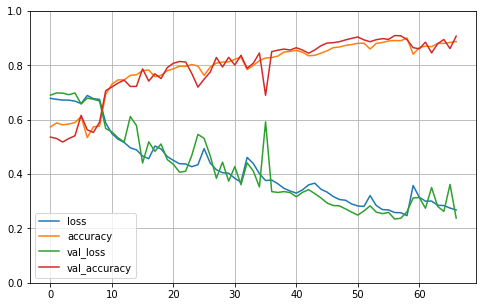

accuracy: 90.96%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 150s 394ms/step - loss: 0.6854 - accuracy: 0.5512 - val_loss: 0.6935 - val_accuracy: 0.5315


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.2.best/assets


Epoch 2/200
350/350 [==============================] - 135s 386ms/step - loss: 0.6697 - accuracy: 0.5917 - val_loss: 0.6911 - val_accuracy: 0.5301
Epoch 3/200
350/350 [==============================] - 136s 388ms/step - loss: 0.6761 - accuracy: 0.5731 - val_loss: 0.6775 - val_accuracy: 0.6122


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.2.best/assets


Epoch 4/200
350/350 [==============================] - 136s 388ms/step - loss: 0.6747 - accuracy: 0.5869 - val_loss: 0.6907 - val_accuracy: 0.5347
Epoch 5/200
350/350 [==============================] - 134s 382ms/step - loss: 0.6789 - accuracy: 0.5770 - val_loss: 0.6496 - val_accuracy: 0.6183


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.2.best/assets


Epoch 6/200
350/350 [==============================] - 134s 384ms/step - loss: 0.6252 - accuracy: 0.6651 - val_loss: 0.5871 - val_accuracy: 0.6946


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.2.best/assets


Epoch 7/200
350/350 [==============================] - 136s 389ms/step - loss: 0.5775 - accuracy: 0.7131 - val_loss: 0.5639 - val_accuracy: 0.7158


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.2.best/assets


Epoch 8/200
350/350 [==============================] - 135s 387ms/step - loss: 0.5514 - accuracy: 0.7305 - val_loss: 0.5250 - val_accuracy: 0.7414


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.2.best/assets


Epoch 9/200
350/350 [==============================] - 134s 384ms/step - loss: 0.5183 - accuracy: 0.7532 - val_loss: 0.4583 - val_accuracy: 0.7876


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.2.best/assets


Epoch 10/200
350/350 [==============================] - 133s 381ms/step - loss: 0.4627 - accuracy: 0.7893 - val_loss: 0.6354 - val_accuracy: 0.6729
Epoch 11/200
350/350 [==============================] - 133s 381ms/step - loss: 0.5784 - accuracy: 0.7014 - val_loss: 0.5655 - val_accuracy: 0.7081
Epoch 12/200
350/350 [==============================] - 132s 377ms/step - loss: 0.5608 - accuracy: 0.7145 - val_loss: 0.5729 - val_accuracy: 0.6994
Epoch 13/200
350/350 [==============================] - 131s 374ms/step - loss: 0.5566 - accuracy: 0.7193 - val_loss: 0.5646 - val_accuracy: 0.7147
Epoch 14/200
350/350 [==============================] - 129s 369ms/step - loss: 0.5510 - accuracy: 0.7249 - val_loss: 0.5480 - val_accuracy: 0.7195
Epoch 15/200
350/350 [==============================] - 129s 369ms/step - loss: 0.5394 - accuracy: 0.7339 - val_loss: 0.5396 - val_accuracy: 0.7258
Epoch 16/200
350/350 [==============================] - 126s 361ms/step - loss: 0.5387 - accuracy: 0.7371 - val_

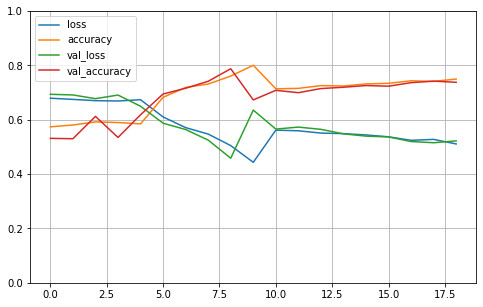

accuracy: 78.76%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 149s 386ms/step - loss: 0.6811 - accuracy: 0.5658 - val_loss: 0.6969 - val_accuracy: 0.5303


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 2/200
350/350 [==============================] - 133s 379ms/step - loss: 0.6760 - accuracy: 0.5779 - val_loss: 0.7064 - val_accuracy: 0.5000
Epoch 3/200
350/350 [==============================] - 133s 381ms/step - loss: 0.7150 - accuracy: 0.4912 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 4/200
350/350 [==============================] - 134s 383ms/step - loss: 0.7019 - accuracy: 0.5032 - val_loss: 0.6393 - val_accuracy: 0.6464


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 5/200
350/350 [==============================] - 135s 386ms/step - loss: 0.6836 - accuracy: 0.5576 - val_loss: 0.7224 - val_accuracy: 0.5174
Epoch 6/200
350/350 [==============================] - 136s 388ms/step - loss: 0.6681 - accuracy: 0.5918 - val_loss: 0.6325 - val_accuracy: 0.6591


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 7/200
350/350 [==============================] - 135s 385ms/step - loss: 0.6389 - accuracy: 0.6478 - val_loss: 0.6152 - val_accuracy: 0.6603


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 8/200
350/350 [==============================] - 137s 391ms/step - loss: 0.5976 - accuracy: 0.6912 - val_loss: 0.5770 - val_accuracy: 0.7108


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 9/200
350/350 [==============================] - 137s 391ms/step - loss: 0.5593 - accuracy: 0.7214 - val_loss: 0.5511 - val_accuracy: 0.7221


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 10/200
350/350 [==============================] - 136s 390ms/step - loss: 0.5470 - accuracy: 0.7401 - val_loss: 0.5612 - val_accuracy: 0.7220
Epoch 11/200
350/350 [==============================] - 137s 392ms/step - loss: 0.5452 - accuracy: 0.7289 - val_loss: 0.5646 - val_accuracy: 0.7143
Epoch 12/200
350/350 [==============================] - 137s 392ms/step - loss: 0.5371 - accuracy: 0.7412 - val_loss: 0.5233 - val_accuracy: 0.7357


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 13/200
350/350 [==============================] - 138s 394ms/step - loss: 0.5338 - accuracy: 0.7392 - val_loss: 0.5230 - val_accuracy: 0.7408


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 14/200
350/350 [==============================] - 136s 390ms/step - loss: 0.5159 - accuracy: 0.7525 - val_loss: 0.4980 - val_accuracy: 0.7569


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 15/200
350/350 [==============================] - 137s 392ms/step - loss: 0.5033 - accuracy: 0.7586 - val_loss: 0.4831 - val_accuracy: 0.7658


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 16/200
350/350 [==============================] - 136s 388ms/step - loss: 0.4913 - accuracy: 0.7703 - val_loss: 0.4710 - val_accuracy: 0.7765


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 17/200
350/350 [==============================] - 134s 383ms/step - loss: 0.4811 - accuracy: 0.7752 - val_loss: 0.5917 - val_accuracy: 0.7201
Epoch 18/200
350/350 [==============================] - 133s 381ms/step - loss: 0.4609 - accuracy: 0.7868 - val_loss: 0.4506 - val_accuracy: 0.7860


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 19/200
350/350 [==============================] - 134s 383ms/step - loss: 0.4224 - accuracy: 0.8107 - val_loss: 0.4306 - val_accuracy: 0.8056


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 20/200
350/350 [==============================] - 135s 387ms/step - loss: 0.3970 - accuracy: 0.8202 - val_loss: 0.5551 - val_accuracy: 0.7111
Epoch 21/200
350/350 [==============================] - 136s 389ms/step - loss: 0.5700 - accuracy: 0.7057 - val_loss: 0.5281 - val_accuracy: 0.7367
Epoch 22/200
350/350 [==============================] - 138s 394ms/step - loss: 0.5360 - accuracy: 0.7274 - val_loss: 0.4983 - val_accuracy: 0.7562
Epoch 23/200
350/350 [==============================] - 138s 394ms/step - loss: 0.5030 - accuracy: 0.7565 - val_loss: 0.6131 - val_accuracy: 0.7004
Epoch 24/200
350/350 [==============================] - 139s 396ms/step - loss: 0.5048 - accuracy: 0.7557 - val_loss: 0.4968 - val_accuracy: 0.7578
Epoch 25/200
350/350 [==============================] - 139s 398ms/step - loss: 0.4804 - accuracy: 0.7745 - val_loss: 0.4530 - val_accuracy: 0.7885
Epoch 26/200
350/350 [==============================] - 139s 397ms/step - loss: 0.4591 - accuracy: 0.7857 - val_

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 29/200
350/350 [==============================] - 140s 400ms/step - loss: 0.4254 - accuracy: 0.8076 - val_loss: 0.3730 - val_accuracy: 0.8374


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 30/200
350/350 [==============================] - 139s 396ms/step - loss: 0.3872 - accuracy: 0.8283 - val_loss: 0.3317 - val_accuracy: 0.8585


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 31/200
350/350 [==============================] - 139s 397ms/step - loss: 0.3617 - accuracy: 0.8365 - val_loss: 0.3712 - val_accuracy: 0.8357
Epoch 32/200
350/350 [==============================] - 139s 398ms/step - loss: 0.3830 - accuracy: 0.8312 - val_loss: 0.3292 - val_accuracy: 0.8593


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 33/200
350/350 [==============================] - 140s 400ms/step - loss: 0.3565 - accuracy: 0.8441 - val_loss: 0.3522 - val_accuracy: 0.8426
Epoch 34/200
350/350 [==============================] - 140s 402ms/step - loss: 0.3261 - accuracy: 0.8607 - val_loss: 0.2822 - val_accuracy: 0.8856


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 35/200
350/350 [==============================] - 142s 406ms/step - loss: 0.3082 - accuracy: 0.8742 - val_loss: 0.2796 - val_accuracy: 0.8909


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 36/200
350/350 [==============================] - 141s 403ms/step - loss: 0.2931 - accuracy: 0.8783 - val_loss: 0.2510 - val_accuracy: 0.9009


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 37/200
350/350 [==============================] - 138s 396ms/step - loss: 0.2857 - accuracy: 0.8806 - val_loss: 0.2673 - val_accuracy: 0.8980
Epoch 38/200
350/350 [==============================] - 139s 398ms/step - loss: 0.2888 - accuracy: 0.8790 - val_loss: 0.2558 - val_accuracy: 0.9008
Epoch 39/200
350/350 [==============================] - 141s 403ms/step - loss: 0.2776 - accuracy: 0.8850 - val_loss: 0.2454 - val_accuracy: 0.9072


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.3.best/assets


Epoch 40/200
350/350 [==============================] - 139s 397ms/step - loss: 0.3481 - accuracy: 0.8506 - val_loss: 0.3308 - val_accuracy: 0.8571
Epoch 41/200
350/350 [==============================] - 136s 390ms/step - loss: 0.3392 - accuracy: 0.8536 - val_loss: 0.3160 - val_accuracy: 0.8662
Epoch 42/200
350/350 [==============================] - 138s 394ms/step - loss: 0.3072 - accuracy: 0.8649 - val_loss: 0.2583 - val_accuracy: 0.8994
Epoch 43/200
350/350 [==============================] - 137s 393ms/step - loss: 0.2782 - accuracy: 0.8839 - val_loss: 0.2527 - val_accuracy: 0.9014
Epoch 44/200
350/350 [==============================] - 137s 392ms/step - loss: 0.2638 - accuracy: 0.8908 - val_loss: 0.2677 - val_accuracy: 0.8958
Epoch 45/200
350/350 [==============================] - 136s 390ms/step - loss: 0.2843 - accuracy: 0.8835 - val_loss: 0.4142 - val_accuracy: 0.8080
Epoch 46/200
350/350 [==============================] - 135s 385ms/step - loss: 0.3772 - accuracy: 0.8303 - val_

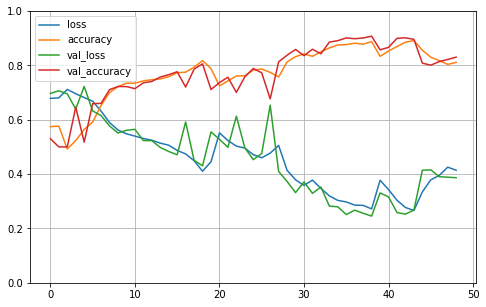

accuracy: 90.72%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 138s 356ms/step - loss: 0.6862 - accuracy: 0.5420 - val_loss: 0.6974 - val_accuracy: 0.5369


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 2/200
350/350 [==============================] - 124s 355ms/step - loss: 0.6725 - accuracy: 0.5802 - val_loss: 0.6912 - val_accuracy: 0.5336
Epoch 3/200
350/350 [==============================] - 122s 349ms/step - loss: 0.6760 - accuracy: 0.5790 - val_loss: 0.7000 - val_accuracy: 0.5336
Epoch 4/200
350/350 [==============================] - 123s 351ms/step - loss: 0.6721 - accuracy: 0.5933 - val_loss: 0.6551 - val_accuracy: 0.6813


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 5/200
350/350 [==============================] - 123s 351ms/step - loss: 0.6552 - accuracy: 0.6204 - val_loss: 0.6954 - val_accuracy: 0.5285
Epoch 6/200
350/350 [==============================] - 126s 361ms/step - loss: 0.6758 - accuracy: 0.5859 - val_loss: 0.6941 - val_accuracy: 0.5603
Epoch 7/200
350/350 [==============================] - 126s 360ms/step - loss: 0.6758 - accuracy: 0.5794 - val_loss: 0.7005 - val_accuracy: 0.5299
Epoch 8/200
350/350 [==============================] - 124s 354ms/step - loss: 0.6714 - accuracy: 0.5816 - val_loss: 0.5925 - val_accuracy: 0.6952


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 9/200
350/350 [==============================] - 123s 351ms/step - loss: 0.5829 - accuracy: 0.7049 - val_loss: 0.5676 - val_accuracy: 0.7177


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 10/200
350/350 [==============================] - 123s 352ms/step - loss: 0.5423 - accuracy: 0.7365 - val_loss: 0.5335 - val_accuracy: 0.7360


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 11/200
350/350 [==============================] - 124s 354ms/step - loss: 0.5326 - accuracy: 0.7412 - val_loss: 0.6574 - val_accuracy: 0.6663
Epoch 12/200
350/350 [==============================] - 124s 355ms/step - loss: 0.5097 - accuracy: 0.7558 - val_loss: 0.4922 - val_accuracy: 0.7620


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 13/200
350/350 [==============================] - 125s 358ms/step - loss: 0.4951 - accuracy: 0.7614 - val_loss: 0.5462 - val_accuracy: 0.7383
Epoch 14/200
350/350 [==============================] - 123s 352ms/step - loss: 0.4714 - accuracy: 0.7849 - val_loss: 0.5068 - val_accuracy: 0.7530
Epoch 15/200
350/350 [==============================] - 124s 355ms/step - loss: 0.4513 - accuracy: 0.7896 - val_loss: 0.4986 - val_accuracy: 0.7630


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 16/200
350/350 [==============================] - 124s 354ms/step - loss: 0.4201 - accuracy: 0.8111 - val_loss: 0.4540 - val_accuracy: 0.7942


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 17/200
350/350 [==============================] - 124s 355ms/step - loss: 0.4245 - accuracy: 0.8028 - val_loss: 0.3899 - val_accuracy: 0.8263


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 18/200
350/350 [==============================] - 123s 352ms/step - loss: 0.3901 - accuracy: 0.8287 - val_loss: 0.3650 - val_accuracy: 0.8383


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 19/200
350/350 [==============================] - 123s 351ms/step - loss: 0.3825 - accuracy: 0.8331 - val_loss: 0.3765 - val_accuracy: 0.8336
Epoch 20/200
350/350 [==============================] - 123s 352ms/step - loss: 0.3764 - accuracy: 0.8333 - val_loss: 0.3990 - val_accuracy: 0.8281
Epoch 21/200
350/350 [==============================] - 125s 359ms/step - loss: 0.3591 - accuracy: 0.8440 - val_loss: 0.3367 - val_accuracy: 0.8551


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 22/200
350/350 [==============================] - 125s 357ms/step - loss: 0.3534 - accuracy: 0.8415 - val_loss: 0.3311 - val_accuracy: 0.8610


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 23/200
350/350 [==============================] - 123s 353ms/step - loss: 0.3444 - accuracy: 0.8519 - val_loss: 0.3299 - val_accuracy: 0.8616


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 24/200
350/350 [==============================] - 124s 355ms/step - loss: 0.3616 - accuracy: 0.8399 - val_loss: 0.2984 - val_accuracy: 0.8744


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 25/200
350/350 [==============================] - 125s 357ms/step - loss: 0.3205 - accuracy: 0.8603 - val_loss: 0.3134 - val_accuracy: 0.8685
Epoch 26/200
350/350 [==============================] - 125s 357ms/step - loss: 0.3114 - accuracy: 0.8677 - val_loss: 0.2862 - val_accuracy: 0.8795


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 27/200
350/350 [==============================] - 125s 356ms/step - loss: 0.3169 - accuracy: 0.8689 - val_loss: 0.2919 - val_accuracy: 0.8801


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 28/200
350/350 [==============================] - 121s 345ms/step - loss: 0.2952 - accuracy: 0.8760 - val_loss: 0.2815 - val_accuracy: 0.8842


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 29/200
350/350 [==============================] - 125s 357ms/step - loss: 0.2912 - accuracy: 0.8771 - val_loss: 0.3689 - val_accuracy: 0.8489
Epoch 30/200
350/350 [==============================] - 123s 353ms/step - loss: 0.2869 - accuracy: 0.8776 - val_loss: 0.2600 - val_accuracy: 0.8984


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 31/200
350/350 [==============================] - 124s 355ms/step - loss: 0.2735 - accuracy: 0.8875 - val_loss: 0.2857 - val_accuracy: 0.8863
Epoch 32/200
350/350 [==============================] - 126s 360ms/step - loss: 0.2642 - accuracy: 0.8934 - val_loss: 0.2749 - val_accuracy: 0.8859
Epoch 33/200
350/350 [==============================] - 128s 367ms/step - loss: 0.2480 - accuracy: 0.8962 - val_loss: 0.2361 - val_accuracy: 0.9099


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 34/200
350/350 [==============================] - 133s 379ms/step - loss: 0.2393 - accuracy: 0.9043 - val_loss: 0.2366 - val_accuracy: 0.9116


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 35/200
350/350 [==============================] - 129s 370ms/step - loss: 0.2158 - accuracy: 0.9120 - val_loss: 0.2086 - val_accuracy: 0.9233


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.4.best/assets


Epoch 36/200
350/350 [==============================] - 128s 365ms/step - loss: 0.2321 - accuracy: 0.9055 - val_loss: 0.2170 - val_accuracy: 0.9186
Epoch 37/200
350/350 [==============================] - 126s 362ms/step - loss: 0.2029 - accuracy: 0.9190 - val_loss: 0.2330 - val_accuracy: 0.9162
Epoch 38/200
350/350 [==============================] - 126s 359ms/step - loss: 0.3097 - accuracy: 0.8657 - val_loss: 0.4265 - val_accuracy: 0.8067
Epoch 39/200
350/350 [==============================] - 127s 363ms/step - loss: 0.3831 - accuracy: 0.8284 - val_loss: 0.3440 - val_accuracy: 0.8500
Epoch 40/200
350/350 [==============================] - 128s 367ms/step - loss: 0.3298 - accuracy: 0.8569 - val_loss: 0.2983 - val_accuracy: 0.8754
Epoch 41/200
350/350 [==============================] - 128s 366ms/step - loss: 0.2973 - accuracy: 0.8714 - val_loss: 0.3580 - val_accuracy: 0.8531
Epoch 42/200
350/350 [==============================] - 127s 363ms/step - loss: 0.2881 - accuracy: 0.8774 - val_

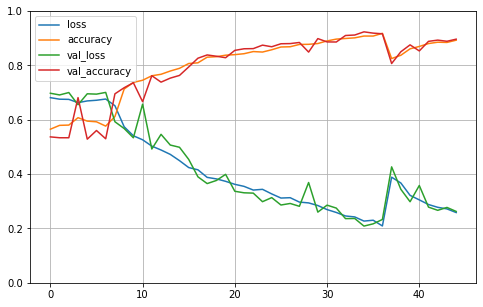

accuracy: 92.33%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 144s 372ms/step - loss: 0.6820 - accuracy: 0.5711 - val_loss: 0.6910 - val_accuracy: 0.5379


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


Epoch 2/200
350/350 [==============================] - 126s 361ms/step - loss: 0.6759 - accuracy: 0.5844 - val_loss: 0.7244 - val_accuracy: 0.5359
Epoch 3/200
350/350 [==============================] - 124s 355ms/step - loss: 0.6886 - accuracy: 0.5447 - val_loss: 0.7004 - val_accuracy: 0.5000
Epoch 4/200
350/350 [==============================] - 126s 360ms/step - loss: 0.6915 - accuracy: 0.5251 - val_loss: 0.6938 - val_accuracy: 0.4975
Epoch 5/200
350/350 [==============================] - 127s 363ms/step - loss: 0.6847 - accuracy: 0.5519 - val_loss: 0.6994 - val_accuracy: 0.5271
Epoch 6/200
350/350 [==============================] - 128s 365ms/step - loss: 0.6734 - accuracy: 0.5873 - val_loss: 0.6927 - val_accuracy: 0.5292
Epoch 7/200
350/350 [==============================] - 128s 367ms/step - loss: 0.6391 - accuracy: 0.6399 - val_loss: 0.5981 - val_accuracy: 0.6909


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


Epoch 8/200
350/350 [==============================] - 129s 370ms/step - loss: 0.5755 - accuracy: 0.7063 - val_loss: 0.5962 - val_accuracy: 0.6994


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


Epoch 9/200
350/350 [==============================] - 130s 371ms/step - loss: 0.5624 - accuracy: 0.7237 - val_loss: 0.5489 - val_accuracy: 0.7207


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


Epoch 10/200
350/350 [==============================] - 132s 376ms/step - loss: 0.5387 - accuracy: 0.7405 - val_loss: 0.5558 - val_accuracy: 0.7290


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


Epoch 11/200
350/350 [==============================] - 128s 366ms/step - loss: 0.5010 - accuracy: 0.7696 - val_loss: 0.4790 - val_accuracy: 0.7719


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


Epoch 12/200
350/350 [==============================] - 127s 364ms/step - loss: 0.4651 - accuracy: 0.7856 - val_loss: 0.4146 - val_accuracy: 0.8192


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


Epoch 13/200
350/350 [==============================] - 127s 363ms/step - loss: 0.4484 - accuracy: 0.7867 - val_loss: 0.5211 - val_accuracy: 0.7426
Epoch 14/200
350/350 [==============================] - 127s 363ms/step - loss: 0.4967 - accuracy: 0.7620 - val_loss: 0.5041 - val_accuracy: 0.7616
Epoch 15/200
350/350 [==============================] - 128s 365ms/step - loss: 0.4123 - accuracy: 0.8134 - val_loss: 0.3934 - val_accuracy: 0.8332


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


Epoch 16/200
350/350 [==============================] - 128s 367ms/step - loss: 0.3885 - accuracy: 0.8304 - val_loss: 0.3578 - val_accuracy: 0.8541


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


Epoch 17/200
350/350 [==============================] - 127s 364ms/step - loss: 0.4418 - accuracy: 0.7935 - val_loss: 0.5038 - val_accuracy: 0.7674
Epoch 18/200
350/350 [==============================] - 128s 367ms/step - loss: 0.4629 - accuracy: 0.7849 - val_loss: 0.3819 - val_accuracy: 0.8347
Epoch 19/200
350/350 [==============================] - 128s 367ms/step - loss: 0.3884 - accuracy: 0.8293 - val_loss: 0.3989 - val_accuracy: 0.8218
Epoch 20/200
350/350 [==============================] - 128s 366ms/step - loss: 0.3997 - accuracy: 0.8139 - val_loss: 0.3680 - val_accuracy: 0.8407
Epoch 21/200
350/350 [==============================] - 128s 367ms/step - loss: 0.3706 - accuracy: 0.8389 - val_loss: 0.3542 - val_accuracy: 0.8499
Epoch 22/200
350/350 [==============================] - 127s 364ms/step - loss: 0.3573 - accuracy: 0.8437 - val_loss: 0.3471 - val_accuracy: 0.8524
Epoch 23/200
350/350 [==============================] - 128s 367ms/step - loss: 0.3479 - accuracy: 0.8475 - val_

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


Epoch 27/200
350/350 [==============================] - 127s 364ms/step - loss: 0.4325 - accuracy: 0.7954 - val_loss: 0.5288 - val_accuracy: 0.7387
Epoch 28/200
350/350 [==============================] - 128s 365ms/step - loss: 0.4534 - accuracy: 0.7942 - val_loss: 0.3523 - val_accuracy: 0.8561
Epoch 29/200
350/350 [==============================] - 128s 365ms/step - loss: 0.3751 - accuracy: 0.8304 - val_loss: 0.3568 - val_accuracy: 0.8509
Epoch 30/200
350/350 [==============================] - 129s 370ms/step - loss: 0.3473 - accuracy: 0.8498 - val_loss: 0.3397 - val_accuracy: 0.8576
Epoch 31/200
350/350 [==============================] - 129s 370ms/step - loss: 0.3247 - accuracy: 0.8638 - val_loss: 0.3097 - val_accuracy: 0.8771


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK1.cv.5.best/assets


Epoch 32/200
350/350 [==============================] - 129s 369ms/step - loss: 0.3472 - accuracy: 0.8542 - val_loss: 0.3508 - val_accuracy: 0.8517
Epoch 33/200
350/350 [==============================] - 129s 369ms/step - loss: 0.3502 - accuracy: 0.8468 - val_loss: 0.3239 - val_accuracy: 0.8693
Epoch 34/200
350/350 [==============================] - 129s 370ms/step - loss: 0.3831 - accuracy: 0.8229 - val_loss: 0.5915 - val_accuracy: 0.6926
Epoch 35/200
350/350 [==============================] - 131s 374ms/step - loss: 0.5226 - accuracy: 0.7432 - val_loss: 0.4227 - val_accuracy: 0.8078
Epoch 36/200
350/350 [==============================] - 130s 372ms/step - loss: 0.4558 - accuracy: 0.7819 - val_loss: 0.5878 - val_accuracy: 0.6841
Epoch 37/200
350/350 [==============================] - 131s 373ms/step - loss: 0.5635 - accuracy: 0.7156 - val_loss: 0.5102 - val_accuracy: 0.7478
Epoch 38/200
350/350 [==============================] - 133s 379ms/step - loss: 0.5151 - accuracy: 0.7496 - val_

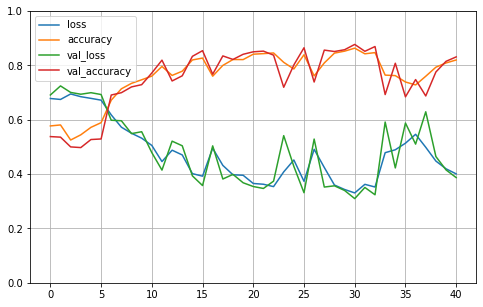

accuracy: 87.71%

5-way Cross Validation max 92.33%, mean 88.10% (+/- 4.91%)
Done


In [8]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model,X_valid,y_valid)  
print ("Done")